# Decision Tree Models

A decision tree is a set of rules combined in a hierarchical manner:
* Sequence of simple decision rules: one feature and one threshold at a time
* No scaling required for numerical features
* `max_depth` controls the trade-off between under-fitting and over-fitting
* Mostly useful as building block for ensemble models: random forest or gradient boosting  decision trees.

## Decision tree in classification

In the following we will illustrate how decision trees fit data with a simple classification problem using the penguins dataset.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helper_kit import plot_decision_function

In [2]:
penguins = pd.read_csv('data/penguins_classification.csv')
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"
penguins.sample(3)

,Culmen Length (mm),Culmen Depth (mm),Species
113,39.6,20.7,Adelie
269,47.2,13.7,Gentoo
115,38.6,17.0,Adelie


In [3]:
from sklearn.model_selection import train_test_split

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(data, target,
                                                                   random_state=0)

range_features = {
    feature_name: (data[feature_name].min() - 1, data[feature_name].max() + 1)
    for feature_name in data.columns }
range_features

{'Culmen Length (mm)': (31.1, 60.6), 'Culmen Depth (mm)': (12.1, 22.5)}

In a previous notebook, we learned that a linear classifier will define a linear separation to split classes using a linear combination of the input features.  
In our 2-dimensional space, it means that a linear classifier will define some oblique lines that best separate our classes. Thus for a linear classifier, we will obtain the following decision boundaries. These boundaries lines indicate where the model changes its prediction from one class to another.

In [5]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(data_train, target_train)

LogisticRegression()

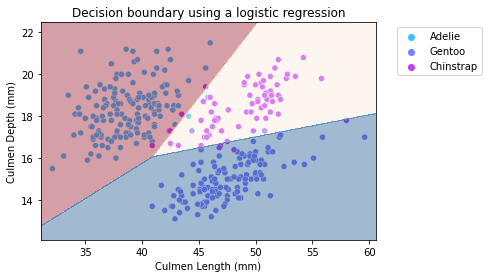

In [9]:
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
               hue='Species', palette='cool')

plot_decision_function(linear_model, range_features, ax=ax)
# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a logistic regression")